In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from monai.transforms import Compose, ScaleIntensity, ToTensor
import numpy as np
import matplotlib.pyplot as plt

from vit_pytorch import ViT
from piq import ssim, multi_scale_ssim
import lpips
from monai.transforms import Resize


from data_loader import MRISliceDataLoader, split_data
from data_loader import MRIGenerationLoader

image_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")









In [2]:
transform = Compose([
    ScaleIntensity(),
    Resize((224, 224)),   # <-- force 224x224
    ToTensor()
])
lpips_metric = lpips.LPIPS(net='alex')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sanmatichoudhary/ADL_Project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanmatichoudhary/ADL_Project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sanmatichoudhary/ADL_Project/myenv/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


## SSL Task

In [3]:
# --- ViT Classifier (for SSL permutation prediction) ---
class ScanOrderViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViT(
            image_size=image_size,
            patch_size=16,
            num_classes=6,
            dim=256,
            depth=4,
            heads=4,
            mlp_dim=512,
            channels=1
        )
        # Detach classifier head so we can use the encoder manually
        self.encoder = self.vit
        self.encoder.mlp_head = nn.Identity()  # <- Important!

        # Now we define the classifier ourselves
        self.classifier = nn.Linear(256, 6)

    def forward(self, x):  # [B*T, 1, H, W]
        return self.encoder(x)  # Returns CLS token features: [B*T, 256]

    def classify(self, batch):  # [B, 3, H, W]
        B, T, H, W = batch.shape
        x = batch.unsqueeze(2).view(B * T, 1, H, W)
        x = self.forward(x)                  # [B*T, 256]
        x = x.view(B, T, -1).mean(dim=1)     # [B, 256]
        return self.classifier(x)            # [B, 6]



### Train Methods

In [4]:
def train_ssl(model, dataloader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            scans = batch["numpy"].to(device)       # [B, 3, H, W]
            labels = batch["label"].to(device)      # [B]

            logits = model.classify(scans)


            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[SSL] Epoch {epoch+1} Loss: {total_loss / len(dataloader):.4f}")



## Predictor/Generator

In [5]:

# --- ViT Encoder + Linear Decoder (for generation task) ---
class TemporalScanPredictor(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.encoder.vit.mlp_head = nn.Identity()
        self.decoder = nn.Linear(256, image_size * image_size)

    def forward(self, x):  # x: [B, 2, 1, H, W]
        B, T, C, H, W = x.shape
        x = x.reshape(B * T, C, H, W)
        feats = self.encoder.vit(x)
        feats = feats.view(B, T, -1).mean(dim=1)
        return self.decoder(feats).view(B, 1, H, W)

### Train Methods

In [18]:
def train_generator(model, dataloader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_seq = batch["input"].to(device)     # [B, 4, 1, H, W]
            target = batch["target"].to(device)       # [B, 1, H, W]

            pred = model(input_seq)                   # → [B, 1, H, W]
            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[GEN] Epoch {epoch+1} Loss: {total_loss / len(dataloader):.4f}")



In [28]:
def evaluate_and_visualize(model, dataloader):
    model.eval()
    total_ssim, total_msssim, total_lpips = 0, 0, 0
    total_mmd, total_cov = 0, 0
    num_batches = 0

    all_real = []
    all_pred = []

    lpips_metric = lpips.LPIPS(net='alex').to(device)

    with torch.no_grad():
        for batch in dataloader:
            input_seq = batch["input"].to(device)     # [B, 4, 1, H, W]
            target = batch["target"].to(device)       # [B, 1, H, W]

            pred = model(input_seq).clamp(0, 1)       # [B, 1, H, W]

            B = pred.size(0)
            for i in range(B):
                real_img = target[i].squeeze().cpu().numpy()
                pred_img = pred[i].squeeze().cpu().numpy()

                fig, axes = plt.subplots(1, 2, figsize=(8, 4))
                axes[0].imshow(real_img, cmap='gray')
                axes[0].set_title("Real Scan")
                axes[1].imshow(pred_img, cmap='gray')
                axes[1].set_title("Predicted Scan")
                for ax in axes:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

            # --- Metrics ---
            total_ssim += ssim(pred, target, data_range=1.0).item()
            total_msssim += multi_scale_ssim(pred, target, data_range=1.0).item()
            total_lpips += lpips_metric(pred, target).mean().item()

            all_real.append(target.view(B, -1).cpu())
            all_pred.append(pred.view(B, -1).cpu())
            num_batches += 1

    # === Global-level metrics ===
    all_real_flat = torch.cat(all_real, dim=0)     # [N, H*W]
    all_pred_flat = torch.cat(all_pred, dim=0)     # [N, H*W]

    total_mmd = calculate_mmd(all_real_flat, all_pred_flat)
    total_cov = calculate_coverage(all_real_flat.numpy(), all_pred_flat.numpy())

    print(f"\n📊 Average Metrics Across {num_batches} Batches")
    print(f"MS-SSIM: {total_msssim / num_batches:.4f}")
    print(f"SSIM:    {total_ssim / num_batches:.4f}")
    print(f"LPIPS:   {total_lpips / num_batches:.4f}")
    print(f"MMD:     {total_mmd:.4f}")
    print(f"Coverage:{total_cov:.4f}")


# Training

#### DataLoaders for Generation & SSL Tasks

In [20]:
data_root = 'numpy_conversions/'
train_ids, test_ids, val_ids = split_data(os.listdir(data_root))

train_set = MRISliceDataLoader(data_root, train_ids, transform=transform)
val_set = MRISliceDataLoader(data_root, val_ids, transform=transform)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

data_root_generation = 'numpy_conversions_5_AD/'

train_ids_generation, test_ids_generation, val_ids_generation = split_data(os.listdir(data_root_generation))


# Use your MRIGenerationLoader with the correct root dir
train_set_generation = MRIGenerationLoader(data_root_generation, train_ids_generation, transform=transform)
val_set_generation = MRIGenerationLoader(data_root_generation, val_ids_generation, transform=transform)

# Wrap the datasets in DataLoaders
train_loader_generation = DataLoader(train_set_generation, batch_size=4, shuffle=True)
val_loader_generation = DataLoader(val_set_generation, batch_size=4, shuffle=False)



### SSL Training

In [30]:
encoder = ScanOrderViT().to(device)
ssl_optimizer = optim.Adam(encoder.parameters(), lr=1e-2)
ssl_criterion = nn.CrossEntropyLoss()
train_ssl(encoder, train_loader, ssl_optimizer, ssl_criterion, epochs=10)

torch.save(encoder.state_dict(), "ssl_vit_encoder.pth")



[SSL] Epoch 1 Loss: 3.4607
[SSL] Epoch 2 Loss: 2.6659
[SSL] Epoch 3 Loss: 1.8673
[SSL] Epoch 4 Loss: 2.4372
[SSL] Epoch 5 Loss: 2.1780
[SSL] Epoch 6 Loss: 2.3018
[SSL] Epoch 7 Loss: 2.3408
[SSL] Epoch 8 Loss: 2.2312
[SSL] Epoch 9 Loss: 2.3666
[SSL] Epoch 10 Loss: 2.0248


### Generation Task Training


Training generator on predicting 5th scan from first 4...
[GEN] Epoch 1 Loss: 0.1071
[GEN] Epoch 2 Loss: 0.0960
[GEN] Epoch 3 Loss: 0.0785
[GEN] Epoch 4 Loss: 0.0690
[GEN] Epoch 5 Loss: 0.0585
[GEN] Epoch 6 Loss: 0.0517
[GEN] Epoch 7 Loss: 0.0453
[GEN] Epoch 8 Loss: 0.0376
[GEN] Epoch 9 Loss: 0.0339
[GEN] Epoch 10 Loss: 0.0304
[GEN] Epoch 11 Loss: 0.0255
[GEN] Epoch 12 Loss: 0.0214
[GEN] Epoch 13 Loss: 0.0208
[GEN] Epoch 14 Loss: 0.0180
[GEN] Epoch 15 Loss: 0.0149
[GEN] Epoch 16 Loss: 0.0139
[GEN] Epoch 17 Loss: 0.0130
[GEN] Epoch 18 Loss: 0.0128
[GEN] Epoch 19 Loss: 0.0116
[GEN] Epoch 20 Loss: 0.0108
[GEN] Epoch 21 Loss: 0.0102
[GEN] Epoch 22 Loss: 0.0093
[GEN] Epoch 23 Loss: 0.0096
[GEN] Epoch 24 Loss: 0.0085
[GEN] Epoch 25 Loss: 0.0078
[GEN] Epoch 26 Loss: 0.0081
[GEN] Epoch 27 Loss: 0.0072
[GEN] Epoch 28 Loss: 0.0079
[GEN] Epoch 29 Loss: 0.0077
[GEN] Epoch 30 Loss: 0.0073
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sanmatichoud

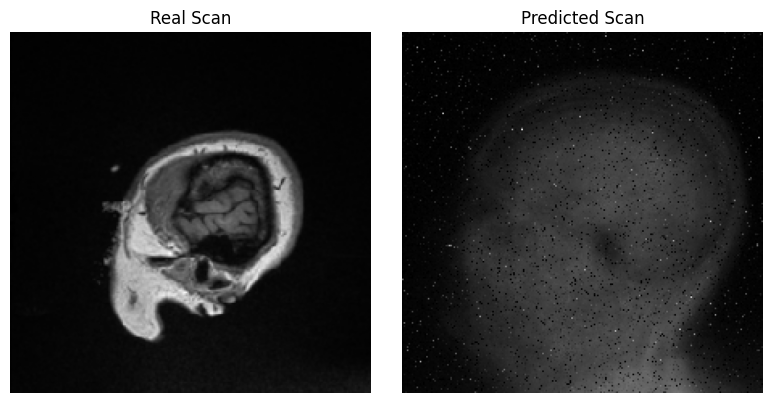

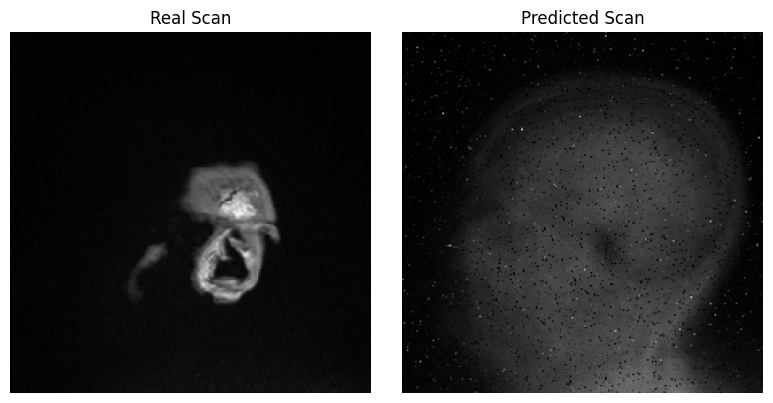

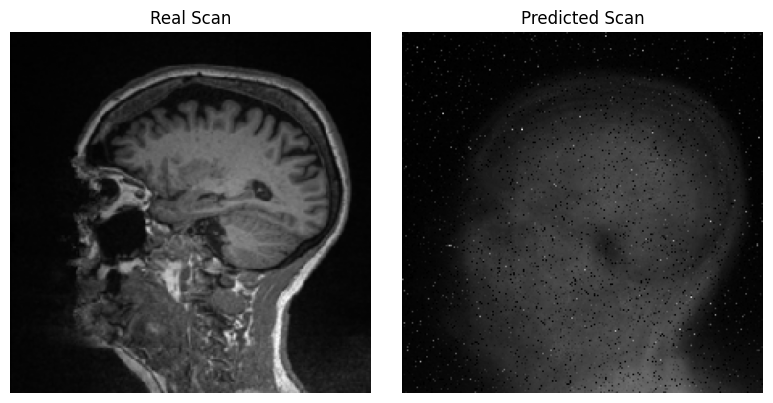

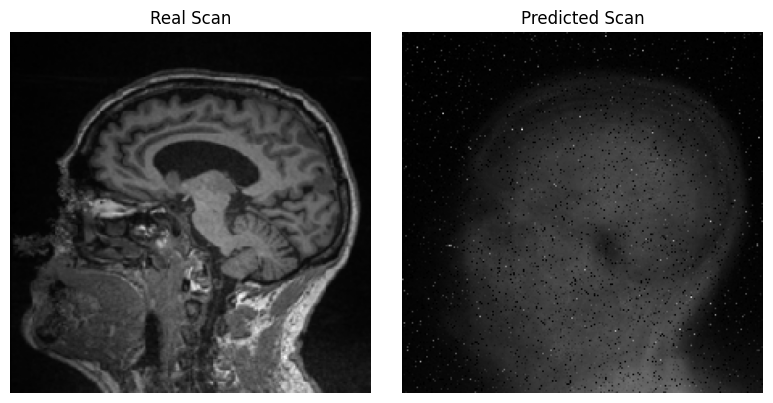

NameError: name 'calculate_mmd' is not defined

In [31]:
print("\nTraining generator on predicting 5th scan from first 4...")

encoder = ScanOrderViT()
encoder.load_state_dict(torch.load("ssl_vit_encoder.pth"))

# Freeze encoder and switch to eval mode
for param in encoder.parameters():
    param.requires_grad = False
encoder.eval()

generator = TemporalScanPredictor(encoder).to(device)
gen_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
gen_criterion = nn.MSELoss()
train_generator(generator, train_loader_generation, gen_optimizer, gen_criterion, epochs=30)



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sanmatichoudhary/ADL_Project/myenv/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


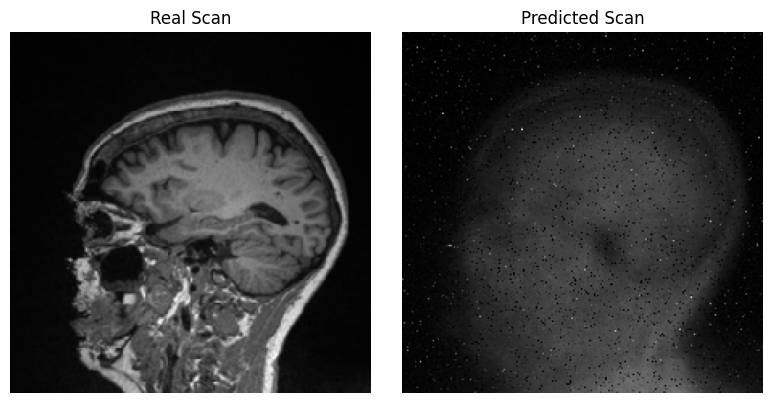

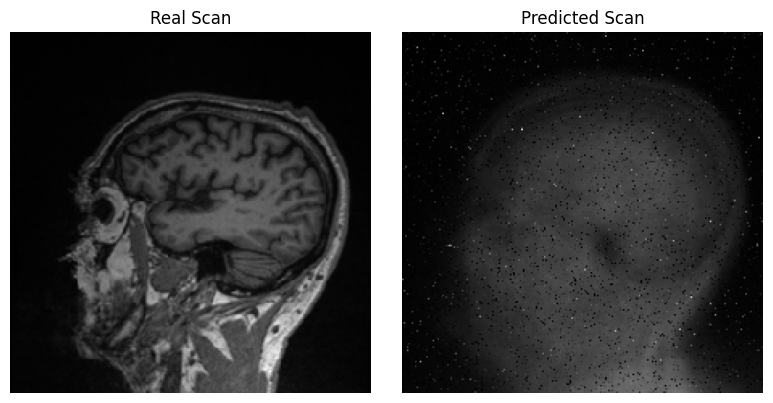

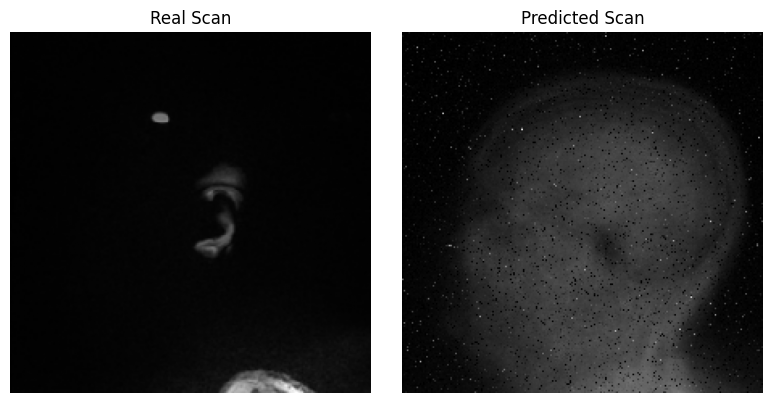

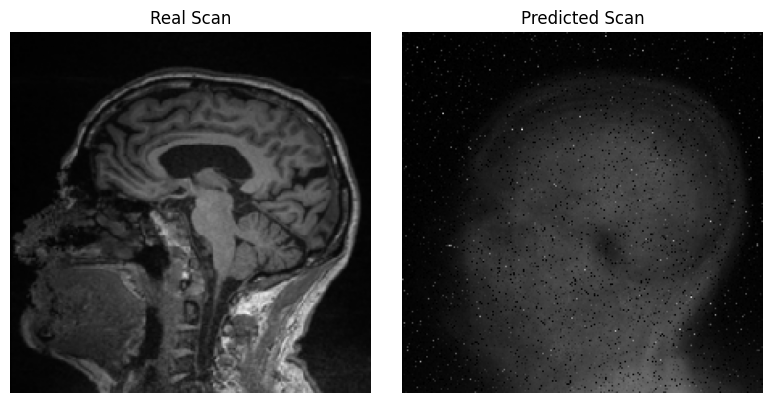


📊 Average Metrics Across 1 Batches
MS-SSIM: 0.5059
SSIM:    0.4416
LPIPS:   0.5623
MMD:     0.8931
Coverage:0.7500


In [33]:
evaluate_and_visualize(generator, val_loader_generation)

### Evaluation Metrics

In [32]:
# Install required packages (only for demonstration purposes, not executable here)
# !pip install torch torchvision numpy scipy lpips piq


from torch.nn.functional import adaptive_avg_pool2d
from torchvision.models import inception_v3
from torchvision import transforms
from piq import ssim, multi_scale_ssim
import lpips 
from torchmetrics.image.kid import KernelInceptionDistance
from typing import Tuple


def calculate_fid(real_features: torch.Tensor, gen_features: torch.Tensor) -> float:
    mu1, sigma1 = real_features.mean(0), torch.cov(real_features.T)
    mu2, sigma2 = gen_features.mean(0), torch.cov(gen_features.T)

    diff = mu1 - mu2
    covmean = linalg.sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(fid)


def calculate_kid(real_images: torch.Tensor, gen_images: torch.Tensor) -> Tuple[float, float]:
    kid = KernelInceptionDistance(subset_size=50)
    kid.update(real_images, real=True)
    kid.update(gen_images, real=False)
    return kid.compute()


def calculate_ms_ssim(real_images: torch.Tensor, gen_images: torch.Tensor) -> float:
    return multi_scale_ssim(gen_images, real_images, data_range=1.0).mean().item()


def calculate_4gr_ssim(real_images: torch.Tensor, gen_images: torch.Tensor) -> float:
    # Use piq SSIM or extend it with gradient and multi-orientation filters
    return ssim(gen_images, real_images, data_range=1.0).mean().item()

def calculate_mmd(x: torch.Tensor, y: torch.Tensor, kernel: str = "rbf", sigma: float = 1.0) -> float:
    def rbf_kernel(a, b, sigma):
        a_norm = (a ** 2).sum(1).view(-1, 1)
        b_norm = (b ** 2).sum(1).view(1, -1)
        dist = a_norm + b_norm - 2 * torch.mm(a, b.T)
        return torch.exp(-dist / (2 * sigma ** 2))

    k_xx = rbf_kernel(x, x, sigma).mean()
    k_yy = rbf_kernel(y, y, sigma).mean()
    k_xy = rbf_kernel(x, y, sigma).mean()
    return float(k_xx + k_yy - 2 * k_xy)


def calculate_coverage(real_features: torch.Tensor, gen_features: torch.Tensor) -> float:
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1).fit(real_features)
    distances, _ = nn.kneighbors(gen_features)
    threshold = np.percentile(distances, 95)
    covered = np.sum(distances <= threshold)
    return covered / len(real_features)


def calculate_lpips(real_images: torch.Tensor, gen_images: torch.Tensor) -> float:
    loss_fn = lpips.LPIPS(net='alex').cuda()
    return loss_fn(gen_images, real_images).mean().item()

